Using TensorFlow backend.


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: steering, dtype: float64
(160, 320, 3)


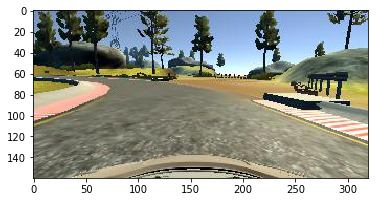

In [1]:
import pandas as pd
import csv
import numpy as np
import keras
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sklearn
%matplotlib inline
image_shape = None

def normalize(x):
    x=x/127.5 - 1.
    return x
def read_image(x):
    return mpimg.imread(x)
def pathchange(x):
    filename = x.split('/')[-1]
    current_path = './data/IMG/'+filename
    return current_path
def visualizing_Data(image_path):
    image = mpimg.imread(image_path)
    global image_shape
    image_shape = image.shape
    print(image.shape)
    plt.imshow(image,cmap="gray")
def data_correcting_path(train_data_path,main_data=False):
    pf  = pd.read_csv(train_data_path)
    pf.center = pf.center.apply(pathchange)
    pf.left = pf.left.apply(pathchange)
    pf.right = pf.right.apply(pathchange)
    pf.steering = pf.steering.astype(float)
    if(main_data):
        return pf
    print(pf.steering.head())
    visualizing_Data(pf.center[2])
    return pf.center,pf.left,pf.right,pf.steering
#     print(pf.center.head())
#     visualizing_Data(pf.center[np.random.randint(len(pf.center))])
#     print("image shape",image_shape)
    
#     ############adding images to train data#######################
#     center_images = [mpimg.imread(x) for x in pf.center]
#     center_images = np.asarray(center_images,dtype=np.float32)
#     print(center_image.shape,type(center_images))
    

center_data,left_data,right_data,steering_data=data_correcting_path('./data/driving_log.csv')



    


In [2]:
def flipped(image, measurement):
  return np.fliplr(image), -measurement

In [3]:
def insert_shadow(image):
    # convert to HSV so that its easy to adjust brightness
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)

    # randomly generate the brightness reduction factor
    # Add a constant so that it prevents the image from being completely dark
    random_bright = .25+np.random.uniform()

    # Apply the brightness reduction to the V channel
    image1[:,:,2] = image1[:,:,2]*random_bright

    # convert to RBG again
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)

    return image

In [4]:
def generate_data_alot(data,batch_size=64):
            from scipy.misc import imread, imsave
            num_samples = len(data)
            while 1: # Loop forever so the generator never terminates
                for offset in range(0, num_samples, batch_size):
                    images = []
                    angles = []
#                     choices = ['left','center','right']
                    choice_correction  = [0.0,0.25,-0.25]
#                     choice_dict = {'left':0.25,'center':0.0,'right':-0.25}
                    for i in range(offset,(offset+batch_size)):  
                            if( i < num_samples):
#                                 choice = random.choice(choices)
                                index = data.index[i]
                                path_list = [data['center'][index],data['left'][index],data['right'][index]]
                                for k in range(len(path_list)):
                                    image = imread(path_list[k])
                                    measurement = data['steering'][index]+choice_correction[k]
                                    if random.random() > 0.5:
                                        image, measurement = flipped(image, measurement)
                                    image = insert_shadow(image)
                                    images.append(image)
                                    angles.append(measurement)
                    yield np.array(images), np.array(angles)
    

In [5]:
def generator_Data(data,batch_size=64):
            from scipy.misc import imread, imsave
            num_samples = len(data)
            while 1: # Loop forever so the generator never terminates
                for offset in range(0, num_samples, batch_size):
                    images = []
                    angles = []
                    choices = ['left','center','right']
                    choice_dict = {'left':0.25,'center':0.0,'right':-0.25}
                    for i in range(offset,(offset+batch_size)):  
                            if( i < num_samples):
                                choice = random.choice(choices)
                                index = data.index[i]
                                path = data[choice][index]
                                image = imread(path)
                                measurement = data['steering'][index]+choice_dict[choice]
                                if random.random() > 0.5:
                                    image, measurement = flipped(image, measurement)
                                images.append(image)
                                angles.append(measurement)
                    yield np.array(images), np.array(angles)
                
                                

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU
from keras.layers.convolutional import Convolution2D,MaxPooling2D
from keras.layers import Cropping2D
from keras.callbacks import EarlyStopping,ModelCheckpoint
def get_nvidia_model():
    model =Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((75,25), (0,0)), input_shape=(160,320,3)))
    model.add(Convolution2D(16, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(32, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Convolution2D(64, 3, 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer="adam", loss="mse")
    model.summary()
    return model

In [10]:
##################model comma ai ##########################
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5 - 1.,
            input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((75,25), (0,0)), input_shape=(160,320,3)))
    model.add(Convolution2D(16, 8, 8, subsample=(4, 4), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(32, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(ELU())
    model.add(Convolution2D(64, 5, 5, subsample=(2, 2), border_mode="same"))
    model.add(Flatten())
    model.add(Dropout(.2))
    model.add(ELU())
    model.add(Dense(512))
    model.add(Dropout(.5))
    model.add(ELU())
    model.add(Dense(1))
    model.summary()
    model.compile(optimizer="adam", loss="mse",metrics = ['accuracy'])
    return model
    
      

In [11]:
def main_model():
    from sklearn.model_selection import train_test_split
    pf = data_correcting_path('./data/driving_log.csv',True)
    
    train_samples, validation_samples = train_test_split(pf, test_size=0.20)
    training_generator = generate_data_alot(train_samples, batch_size = 64)
    validation_generator = generate_data_alot(validation_samples, batch_size = 64)
    callback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto'),
               ModelCheckpoint("weights.{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)]
    model = get_model()
    print(len(train_samples))
    print(len(validation_samples))
    model.fit_generator(
    training_generator,
    samples_per_epoch=len(train_samples)*3,
    nb_epoch=10,
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples),
    callbacks = callback
    )

    model.save('TrainingChangedComma.h5')
    with open("steering_angle.json", "w") as json_file:
          json_file.write(model.to_json())

main_model()
    

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 60, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 15, 80, 16)    3088        cropping2d_1[0][0]               
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 15, 80, 16)    0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [ ]:
model.save('final.h5')